# Project 1 -- Link Prediction

## Introduction

任务为利用机器学习的基本思想：将数据集划分为训练集和测试集；**测试可以进一步使用交叉检验；根据共同邻居思想设计一个学习训练的算法**；根据*Precision*和*AUC*两个评价标准评价自己的学习算法；实验仿真画图展示。


## 初尝试

### 奇怪的bug
在初尝试选择了Jaccard算法，如下。在此之前已经对数据进行分割，划分为训练集和测试集，并且使用了邻接矩阵。

如下

In [ ]:
A = np.matlib.zeros((n,n),dtype = int)  #训练集的邻接矩阵
for a,b in edge_remain:
    a=int(a)
    b=int(b)
    A[a-1,b-1] = 1
    A[b-1,a-1] = 1
print("邻接矩阵")
print(A)
B=A*A #邻接矩阵A的平方
for a,b in edge_remain:
    a=int(a)
    b=int(b)
    B[a-1,b-1] = 0
    B[b-1,a-1] = 0
print("邻接矩阵A的平方--B")
print(B)
#实现Jaccard计算
C = np.bitwise_xor(A,1) #C是邻接矩阵A的反转
G_adverse = nx.from_numpy_matrix(np.array(C)) #G_adverse是G的补图
edge_predict=G_adverse.edges()
pred_jaccard = [] #Jaccard
for a,b in edge_predict:
    if(a!=b):
        a=int(a)
        b=int(b)
        if B[a,a]+B[b,b]-B[a,b] > 0:
            pred_jaccard.append((str(a+1),str(b+1),B[a,b]/(B[a,a]+B[b,b]-B[a,b]))) #利用并集和交集的关系计算0
        else:
            pred_jaccard.append((str(a+1),str(b+1),0))
score, label= zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_jaccard])
# print("pred_jaccard=",pred_jaccard)




这种方式存在一些问题。

实际测试中，出现的问题：

NaN报错、矩阵过大（邻接矩阵对储存空间的利用率很低，但是更方便人进行理解，也更方便数学表征）、偶发性爆内存等等。

### 分析

遇到这个问题，我与室友展开了激烈的讨论。
我认为是Jaccard算法自身原因造成，用到了除法，而除法如果有分母为零的情况就会报错。
如下：

```latex

$$
s_{x y}^{J C}=\frac{C N}{k_{x}+k_{y}-C N}
$$
k: degree of a node

```
比如：如果有两个孤立点，分母：0+0+0=0,除法则会报错，这是运行网上找的另一个程序(test.ipynb)时的报错提醒的。

untimeWarning: invalid value encountered in true_divide
  sim = sim / ( np.multiply( deg_row_matrix, sim1 ) - sim )

输出结果里面有一堆NaN，(以下来自Github Copilot的自动补全：这是因为除法的分母为0，所以计算结果为NaN。）


### 创新

既然分母可能为零，那我们就尝试可以优化算法，避免这种情况发生。

1.强制加一：分析可知分母非负，若分子总是加一，则分母不可能为零，问题得到解决。这种方式在分母较大时对结果影响不大，在分母较小时有不小影响。
2.特判：对于分母为零的情况，给他们的分数设置为极小值，表示几乎完全没有联系，关系十分疏远，符合前文所述“两个孤立点”的情况。

最后，NaN问题得到解决，程序稳定性大幅提升，但对于大数据，矩阵空间还是会爆。

通过这样一波折腾，也算是发明了一种算法：
***Jaccard Plus One Algorithm***
同理，也可以用这种逻辑优化 ***Resource Allocation***、 ***Adamic-Adar*** 算法。

大大的狗头，其实是自己的程序鲁棒性不好，于是就用上了轮子。


## 再次尝试

Number of nodes: 77
Number of edges: 254
Number of connected components: 1


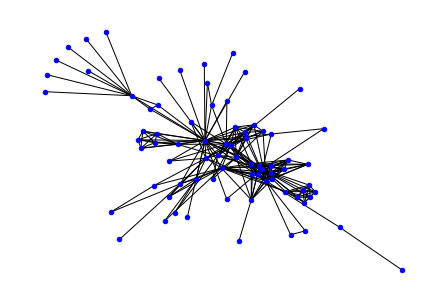

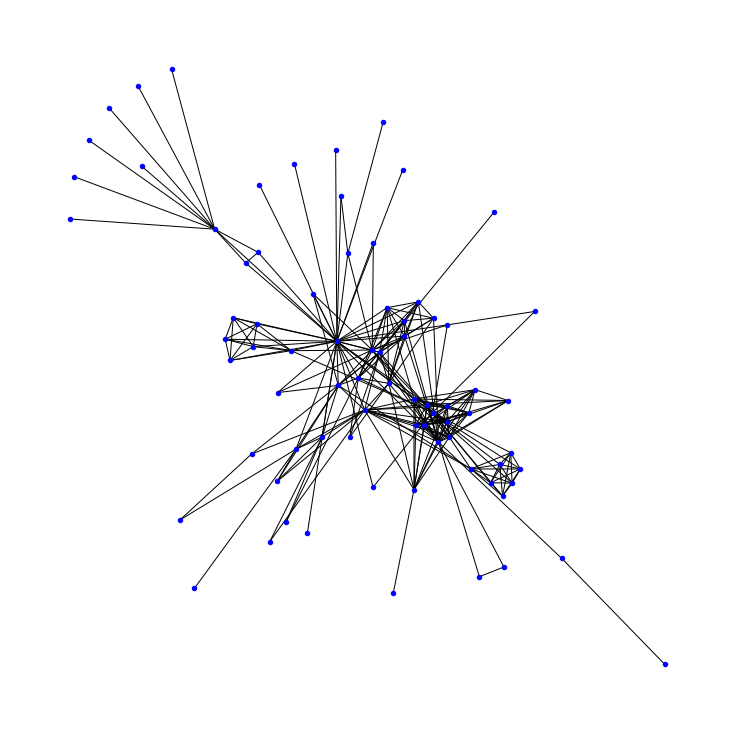

In [78]:
# 先进行一个库的导入。
import numpy as np
import random
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# 这里选择一个简单的图进行演示：networkx famous social network 自带的 悲惨世界图
# 详情：les_miserables_graph()
# Returns coappearance network of characters in the novel Les Miserables
# 实际上，程序已经经过Jazz Politicalblogs SciMet 三个网络的测试

G=nx.les_miserables_graph()
pos=nx.spring_layout(G)

# 打印图的相关信息
nx.draw(G,pos,node_size=20,node_color='blue',with_labels=False)
n=G.number_of_nodes()
m=G.number_of_edges()
print('Number of nodes:',n)
print('Number of edges:',e)
print("Number of connected components: %d" % nx.number_connected_components(G))

plt.figure(figsize=(10,10))
nx.draw(G,pos,node_size=20,node_color='blue',with_labels=False)
plt.show()


Deleted :  63
Remaining :  191


C:\Users\jienb\AppData\Local\Temp/ipykernel_36760/1235768419.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edge_subset = random.sample(G.edges(), int(0.25 * G.number_of_edges()))


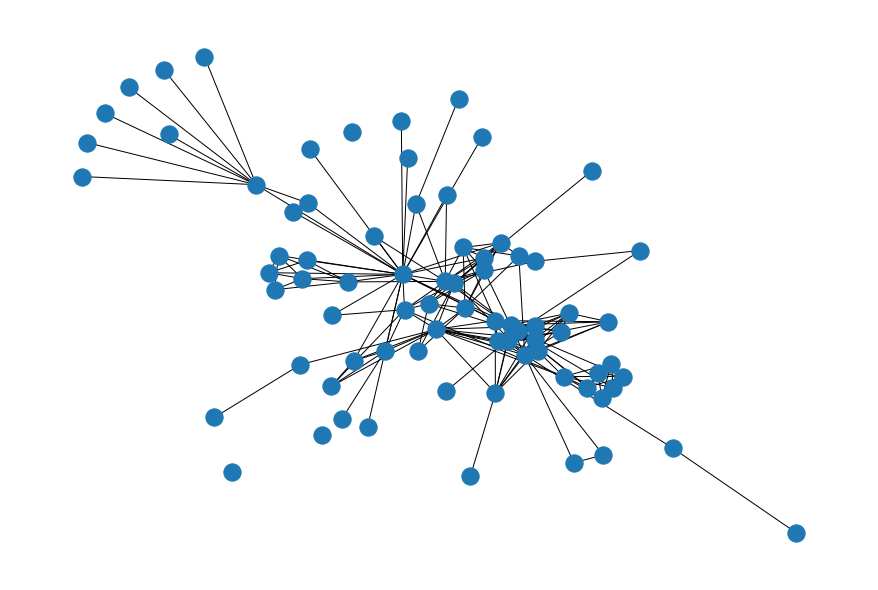

In [79]:
# 现在，让我们删除一些连接，例如25％的边：
# Take a random sample of edges
edge_subset = random.sample(G.edges(), int(0.25 * G.number_of_edges()))
# remove some edges
G_train = G.copy()
G_train.remove_edges_from(edge_subset)

# 绘制部分观察到的图，可以对比上图发现，去掉了一些边
plt.figure(figsize=(12,8))
nx.draw(G_train, pos=pos)

# 你可以打印我们删除的边数和剩余边数：
edge_subset_size = len(list(edge_subset))
print("Deleted : ", str(edge_subset_size))
print("Remaining : ", str((m - edge_subset_size)))

### Jaccard

In [80]:
pred_jaccard = list (nx.jaccard_coefficient ( G_train ))
score_jaccard,label_jaccard = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_jaccard])
# 打印前10组结果
for i in range(10) :
    print(pred_jaccard[i],end='\n')
# 预测结果如下，其中第一个是节点，第二个是节点，最后一个是Jaccard分数（用来表示两个节点之间边预测的概率）

('Feuilly', 'MlleGillenormand', 0.07692307692307693)
('Feuilly', 'Tholomyes', 0.058823529411764705)
('Feuilly', 'Scaufflaire', 0.0)
('Feuilly', 'Labarre', 0.0)
('Feuilly', 'Myriel', 0.0)
('Feuilly', 'Champtercier', 0.0)
('Feuilly', 'CountessDeLo', 0.0)
('Feuilly', 'Fameuil', 0.0)
('Feuilly', 'MmeHucheloup', 0.6)
('Feuilly', 'Thenardier', 0.10526315789473684)


In [81]:
# 然后我们可以使用ROC-AUC标准来比较不同模型的性能，因为我们既有真实的边（label），也有预测边的概率（score）
# Compute the ROC AUC Score
# 其中，FPR是False Positive Rate， TPR是True Positive Rate
fpr_jaccard, tpr_jaccard, _ = roc_curve(label_jaccard, score_jaccard)
auc_jaccard = roc_auc_score(label_jaccard, score_jaccard)
print("AUC of Jaccard : " ,auc_jaccard)


AUC of Jaccard :  0.8519006659267481


In [82]:
# 计算Adamic-Adar
# 我们现在计算Adamic-Adar指数和对应的ROC-AUC分数
# Prediction using Adamic Adar 
pred_adamic = list(nx.adamic_adar_index(G_train))
score_adamic, label_adamic = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_adamic])
for i in range ( 10 ):
    print(pred_adamic[i],end='\n')
# Compute the ROC AUC Score
fpr_adamic, tpr_adamic, _ = roc_curve(label_adamic, score_adamic)
auc_adamic = roc_auc_score(label_adamic, score_adamic)
print("AUC of Adamic-Adar : ",auc_adamic)

('Feuilly', 'MlleGillenormand', 0.36067376022224085)
('Feuilly', 'Tholomyes', 0.36067376022224085)
('Feuilly', 'Scaufflaire', 0)
('Feuilly', 'Labarre', 0)
('Feuilly', 'Myriel', 0)
('Feuilly', 'Champtercier', 0)
('Feuilly', 'CountessDeLo', 0)
('Feuilly', 'Fameuil', 0)
('Feuilly', 'MmeHucheloup', 2.5650509852503918)
('Feuilly', 'Thenardier', 0.7213475204444817)
AUC of Adamic-Adar :  0.8840697835738068


In [83]:
# 计算Preferential Attachment
# 同样，我们可以计算Preferential Attachment得分和对应的ROC-AUC分数
# Compute the Preferential Attachment
pred_pref = list(nx.preferential_attachment(G_train))
score_pref, label_pref = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_pref])
for i in range( 10 ):
    print(pred_pref[i],end='\n')
fpr_pref, tpr_pref, _ = roc_curve(label_pref, score_pref)
auc_pref = roc_auc_score(label_pref, score_pref)
print("AUC of Preferential Attachment : ",auc_pref)

('Feuilly', 'MlleGillenormand', 40)
('Feuilly', 'Tholomyes', 80)
('Feuilly', 'Scaufflaire', 0)
('Feuilly', 'Labarre', 10)
('Feuilly', 'Myriel', 90)
('Feuilly', 'Champtercier', 10)
('Feuilly', 'CountessDeLo', 10)
('Feuilly', 'Fameuil', 60)
('Feuilly', 'MmeHucheloup', 60)
('Feuilly', 'Thenardier', 110)
AUC of Preferential Attachment :  0.7328951627820941


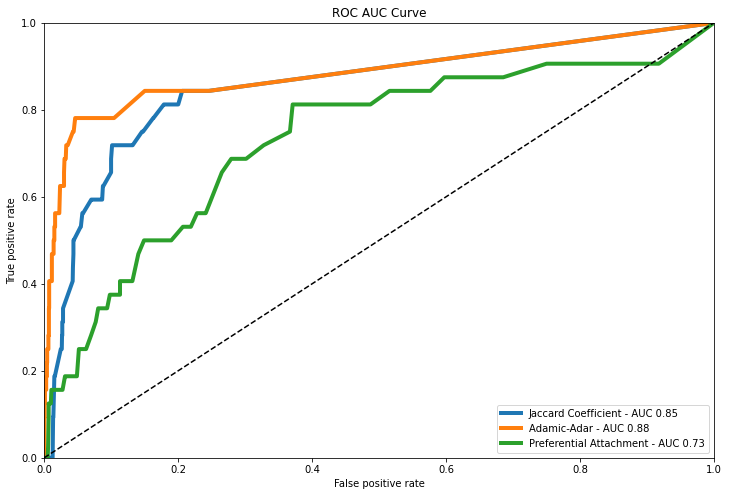

In [84]:
# 绘制ROC-AUC来评价预测的效果
plt.figure(figsize=(12, 8))
plt.plot(fpr_jaccard, tpr_jaccard, label='Jaccard Coefficient - AUC %.2f' % auc_jaccard, linewidth=4)
plt.plot(fpr_adamic, tpr_adamic, label='Adamic-Adar - AUC %.2f' % auc_adamic, linewidth=4)
plt.plot(fpr_pref, tpr_pref, label='Preferential Attachment - AUC %.2f' % auc_pref, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC AUC Curve")
plt.legend(loc='lower right')
plt.show() 

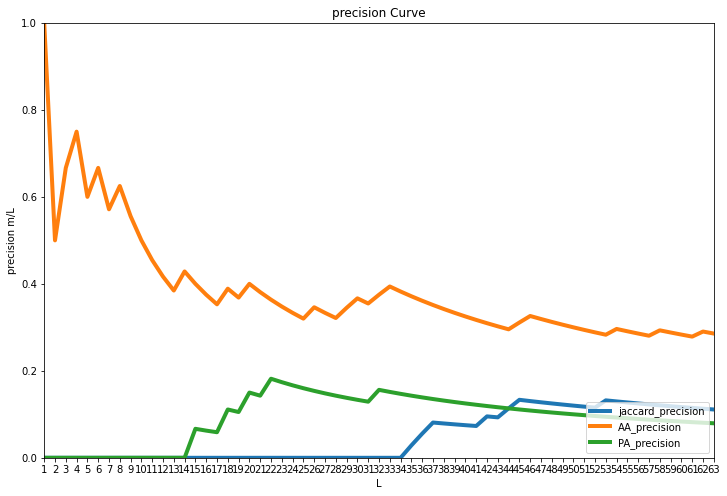

In [85]:
# 画出 Precision 图
L=edge_subset_size
pred_jaccard_p = pred_jaccard
pred_adamic_p = pred_adamic
pred_pref_p = pred_pref

pred_jaccard_p=sorted(pred_jaccard_p,key=lambda score: score[2])
pred_adamic_p=sorted(pred_adamic_p,key=lambda score: score[2])
pred_pref_p=sorted(pred_pref_p,key=lambda score: score[2])

pred_jaccard_p.reverse()
pred_adamic_p.reverse()
pred_pref_p.reverse()

jaccard_score_p, jaccard_label_p= zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_jaccard_p])
adamic_score_p, adamic_label_p= zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_adamic_p])
pref_score_p, pref_label_p= zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_pref_p])

jaccard_precision=[]
AA_precision=[]
PA_precision=[]
a=0
b=0
c=0
for i in range(L):
    if jaccard_label_p[i]:
        a=a+1
    if adamic_label_p[i]:
        b=b+1
    if pref_label_p[i]:
        c=c+1
    jaccard_precision.append(a/(i+1))
    AA_precision.append(b/(i+1))
    PA_precision.append(c/(i+1))


plt.figure(figsize=(12, 8))
plt.plot(range(1,L+1), jaccard_precision, label='jaccard_precision', linewidth=4)
plt.plot(range(1,L+1), AA_precision, label='AA_precision', linewidth=4)
plt.plot(range(1,L+1), PA_precision, label='PA_precision', linewidth=4)
plt.xlim([1, L])
plt.ylim([0.0, 1])
x = range(1,L+1,1)
plt.xticks(x)
plt.xlabel('L')
plt.ylabel('precision m/L')
plt.title("precision Curve")
plt.legend(loc='lower right')
plt.show()



## 总结

这次项目使用了开源的轮子中的几种算法“玩”了一下Link Prediction，在探索的过程中，发现问题，解决问题，最后基本完成任务，达到要求。

# References

1. networkx: https://networkx.github.io/
2. networkx totrial: https://networkx.github.io/documentation/latest/tutorial.html
3. numpy: https://www.numpy.org/
4. ……